In [1]:
import torch
import os
import numpy as np
from PIL import Image
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_score, recall_score
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [2]:
test_data_dir = 'app/data/dataset/test'

In [3]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, image_transform=None, label_transform=None):
        self.normal_dir = img_dir + '/NORMAL'
        self.pneumonia_dir = img_dir + '/PNEUMONIA'
        self.images_list = []  
        self.image_transform = image_transform
        for f in os.listdir(self.normal_dir):
            self.images_list.append(os.path.join(self.normal_dir, f))
        for f in os.listdir(self.pneumonia_dir):
            self.images_list.append(os.path.join(self.pneumonia_dir, f))
            
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = self.images_list[idx]
        if 'NORMAL' in img_name:
            label = 0
        else:
            label = 1
        label = torch.tensor(label, dtype=torch.float32)
        image = Image.open(img_name).convert('RGB')
        image_augmented = self.image_transform(image)
        return image_augmented, label

    
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [4]:
test_dataset = CustomDataset(img_dir=test_data_dir, image_transform=test_transform)

In [5]:
efficientnet_model = models.efficientnet_v2_s(weights=None)
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_features, 1)  

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.load_state_dict(torch.load('EN weigths/efficient_93_acc.pth'))

<All keys matched successfully>

In [7]:
YOLO_model = YOLO("app/data/weights/yolo_96_acc.pt") 

Accuracy: 93.43%
Precision: 94.40%
Recall: 95.13%


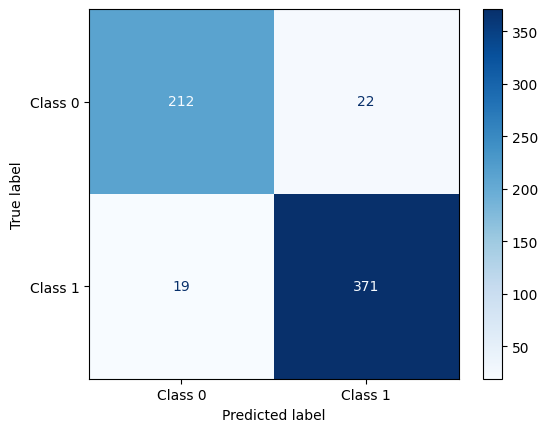

In [8]:
# EfficientNet on test dataset
all_targets = []
all_predictions = []

efficientnet_model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for image, label in test_dataset:
        image = image.to(device)
        label = label.to(device)
        image = image.unsqueeze(0)
        label = label.unsqueeze(0)
        outputs = efficientnet_model(image)
        outputs = outputs.squeeze(1)
        
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).float()
        correct_predictions += (predicted == label).sum().item()
        total_predictions += 1

        # Сохраняем истинные и предсказанные метки
        all_targets.extend(label.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')


conf_matrix = confusion_matrix(all_targets, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


Accuracy: 95.51%
Precision: 94.15%
Recall: 98.97%


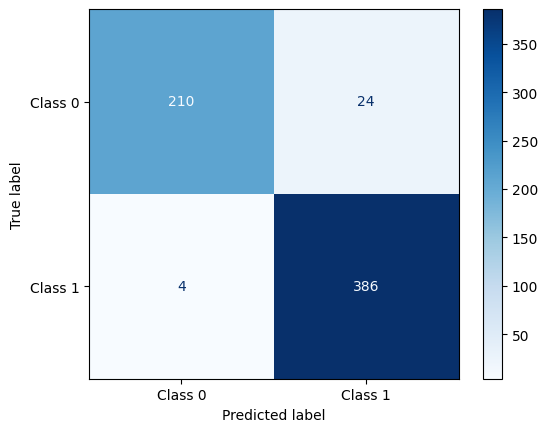

In [9]:
# YOLO on test dataset
all_targets = []
all_predictions = []

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for image, label in test_dataset:
        image = image.to(device)
        label = label.to(device)
        image = image.unsqueeze(0)
        label = label.unsqueeze(0)
        outputs = YOLO_model(image, verbose=False)

        probs = outputs[0].probs
        predicted_label = np.argmax((probs.data).cpu().detach().numpy())
        
        predicted_label = torch.tensor([predicted_label])
        predicted_label = predicted_label.to(device)
        correct_predictions += (predicted_label == label).sum().item()
        total_predictions += 1

        # Сохраняем истинные и предсказанные метки
        all_targets.extend(label.cpu().numpy())
        all_predictions.extend(predicted_label.cpu().numpy())

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(all_targets, all_predictions)
recall = recall_score(all_targets, all_predictions)
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')


conf_matrix = confusion_matrix(all_targets, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
